In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 查看工作路径
import os

print(os.getcwd())


# 修改工作路径
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/ML"
os.chdir(path)
print(os.getcwd())

/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ML


首先要对数据进行预处理。
这里先求出每个故障类型、每个特征的平均值，然后用这个平均值填入源文件。

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 加载数据
df = pd.read_csv('./train_10000.csv')

# 处理缺失值
for label in range(6):
    for feature in range(107):
        feature_name = f'feature{feature}'
        mean_value = df[df['label'] == label][feature_name].mean()
        df.loc[(df['label'] == label) & (df[feature_name].isnull()), feature_name] = mean_value

# 保存处理后的文件
df.to_csv('./train_10000_filled.csv', index=False)

# 分割数据集
train, validation_and_test = train_test_split(df, test_size=0.3, random_state=42)
validation, test = train_test_split(validation_and_test, test_size=0.5, random_state=42)

# 保存分割后的数据集
train.to_csv('./train_set.csv', index=False)
validation.to_csv('./validation_set.csv', index=False)
test.to_csv('./test_set.csv', index=False)


然后用随机森林，对每一个故障类型求出不同的特征对其重要性。

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np

# 初始一个空的DataFrame用于存储所有故障类型的特征重要性
df = pd.read_csv('./train_10000_filled.csv')

# 获取特征和标签
X = df.iloc[:, 1:-1]  # 取feature0到feature106作为特征
y = df['label']  # 取'label'列作为标签

all_importances = pd.DataFrame(index=X.columns)

# 使用分层K折交叉验证
skf = StratifiedKFold(n_splits=5)

for fault_type in range(6):
    # 对于每个故障类型，我们将该类型标记为1，其他类型标记为0
    y_binary = (y == fault_type).astype(int)

    feature_importances = []

    for train_index, test_index in skf.split(X, y_binary):
        # 训练随机森林分类器
        clf = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=5, min_samples_split=10)
        clf.fit(X.iloc[train_index], y_binary.iloc[train_index])

        # 获取并存储特征重要性
        feature_importances.append(clf.feature_importances_)

    # 通过所有交叉验证的平均值获取特征重要性
    all_importances[f'FaultType {fault_type}'] = np.mean(feature_importances, axis=0)

# 保存特征重要性到CSV文件
all_importances.to_csv('./all_feature_importances.csv')



创建热力图，看的更直观哪些特征影响力大

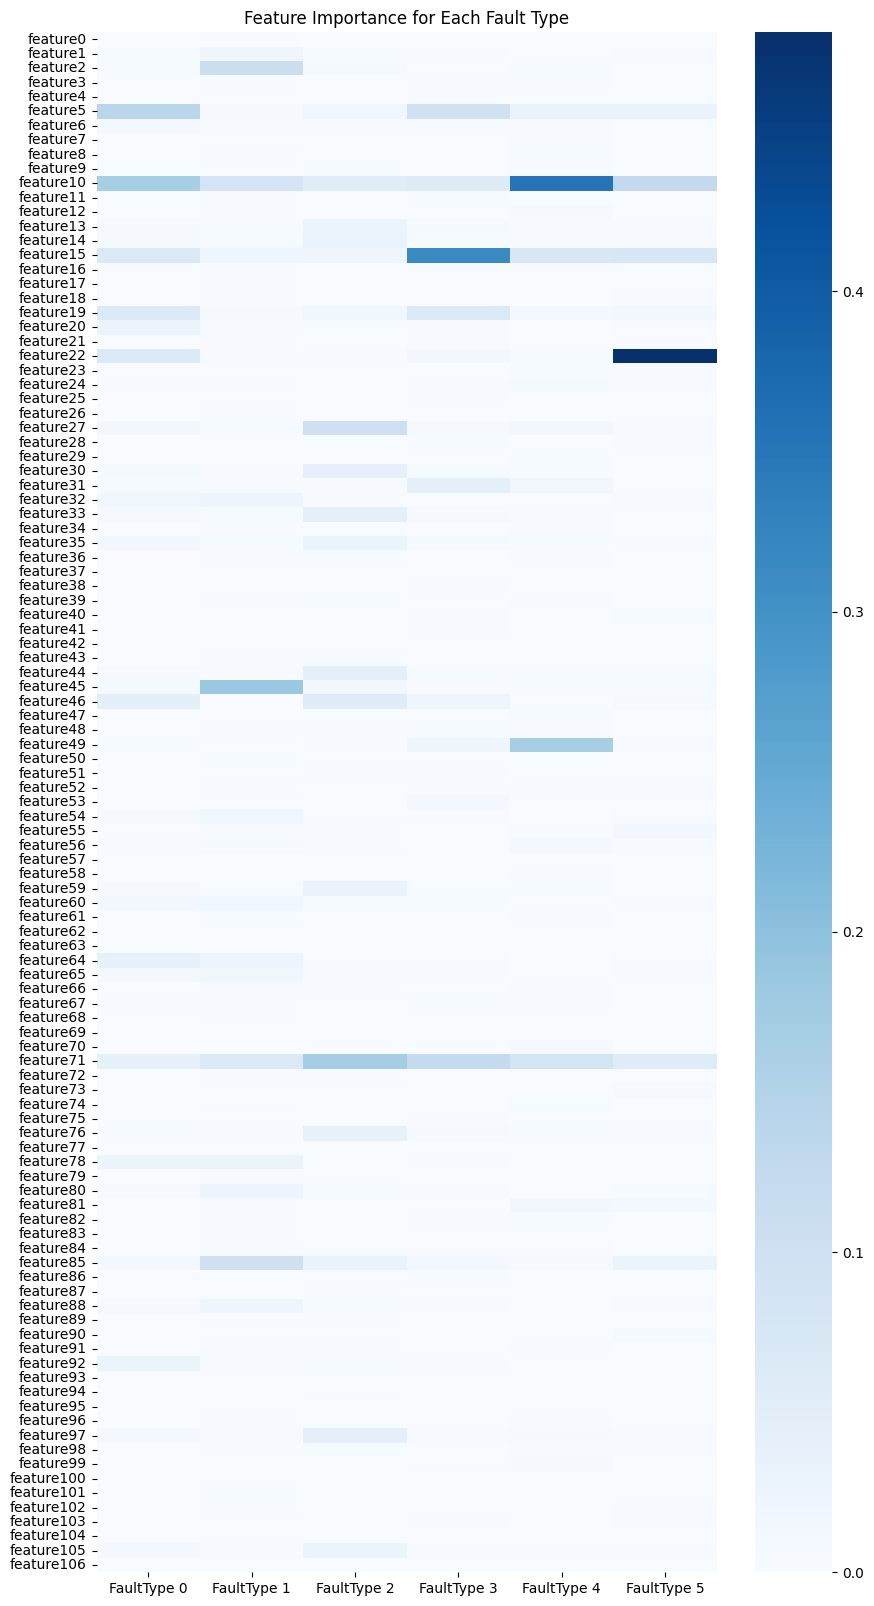

In [5]:
# 创建热力图
plt.figure(figsize=(10, 20))
sns.heatmap(all_importances, cmap='Blues')
plt.title('Feature Importance for Each Fault Type')
plt.show()

下面开始构建模型，首先选出影响力大的所有特征

In [6]:
all_importances = pd.read_csv('./all_feature_importances.csv', index_col=0)
# 为每个故障类型选择前6个最重要的特征
important_features_per_fault = {}
for fault_type in all_importances.columns:
    top_6_features = all_importances[fault_type].sort_values(ascending=False)[:6]
    important_features_per_fault[fault_type] = list(top_6_features.index)


# 打印结果
for fault_type, features in important_features_per_fault.items():
    print(f"For {fault_type}, the most important features are {features}")

# 合并所有的重要特征到一个集合
selected_features = set()

for features in important_features_per_fault.values():
    selected_features.update(features)

print("最终选择的特征有：",selected_features)

For FaultType 0, the most important features are ['feature10', 'feature5', 'feature15', 'feature19', 'feature22', 'feature46']
For FaultType 1, the most important features are ['feature45', 'feature2', 'feature85', 'feature10', 'feature71', 'feature78']
For FaultType 2, the most important features are ['feature71', 'feature27', 'feature46', 'feature10', 'feature97', 'feature44']
For FaultType 3, the most important features are ['feature15', 'feature71', 'feature5', 'feature19', 'feature10', 'feature31']
For FaultType 4, the most important features are ['feature10', 'feature49', 'feature71', 'feature15', 'feature5', 'feature27']
For FaultType 5, the most important features are ['feature22', 'feature10', 'feature15', 'feature71', 'feature5', 'feature85']
最终选择的特征有： {'feature44', 'feature49', 'feature78', 'feature22', 'feature97', 'feature5', 'feature27', 'feature15', 'feature85', 'feature71', 'feature2', 'feature45', 'feature10', 'feature31', 'feature19', 'feature46'}


然后开始构建模型训练

In [36]:
# from sklearn.neural_network import MLPClassifier
import csv
from sklearn.preprocessing import StandardScaler

# 加载数据
df_train = pd.read_csv('./train_set.csv')
df_val = pd.read_csv('./validation_set.csv')
df_test = pd.read_csv('./test_set.csv')

# 选择重要的特征
X_train = df_train[selected_features].values
y_train = df_train['label'].values
X_val = df_val[selected_features].values
y_val = df_val['label'].values
X_test = df_test[selected_features].values
y_test = df_test['label'].values

# 将验证集和训练集合并
x_training_data_final = np.vstack((X_train,X_val))
y_training_data_final = np.append(y_train,y_val)

# 标准化数据
scaler = StandardScaler()
x_training_data_final = scaler.fit_transform(x_training_data_final)
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


mlp = MLPClassifier(solver='sgd', activation='relu', alpha=1e-4, hidden_layer_sizes=(64,64,64), random_state=42,max_iter=300,verbose=True,learning_rate_init=0.05,learning_rate="adaptive")
mlp.fit(x_training_data_final, y_training_data_final)
print("finished")

<ipython-input-36-7b5de95bcb9b>:11: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train = df_train[selected_features].values
<ipython-input-36-7b5de95bcb9b>:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_val = df_val[selected_features].values
<ipython-input-36-7b5de95bcb9b>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test = df_test[selected_features].values


Iteration 1, loss = 0.98236663
Iteration 2, loss = 0.34670933
Iteration 3, loss = 0.26122147
Iteration 4, loss = 0.23249110
Iteration 5, loss = 0.21516804
Iteration 6, loss = 0.20006709
Iteration 7, loss = 0.19535497
Iteration 8, loss = 0.18549567
Iteration 9, loss = 0.17610773
Iteration 10, loss = 0.17487924
Iteration 11, loss = 0.16601145
Iteration 12, loss = 0.16241067
Iteration 13, loss = 0.15783256
Iteration 14, loss = 0.15547610
Iteration 15, loss = 0.15158540
Iteration 16, loss = 0.15636832
Iteration 17, loss = 0.15081982
Iteration 18, loss = 0.14273165
Iteration 19, loss = 0.14120327
Iteration 20, loss = 0.14093510
Iteration 21, loss = 0.13429172
Iteration 22, loss = 0.13137144
Iteration 23, loss = 0.16340460
Iteration 24, loss = 0.13131190
Iteration 25, loss = 0.13696564
Iteration 26, loss = 0.13402945
Iteration 27, loss = 0.12537796
Iteration 28, loss = 0.12267557
Iteration 29, loss = 0.11658826
Iteration 30, loss = 0.11454916
Iteration 31, loss = 0.11616869
Iteration 32, los

In [37]:
print(mlp.score(X_test, y_test))
print(mlp.classes_)

0.9653333333333334
[0 1 2 3 4 5]


In [53]:
print(mlp.predict(X_test))
print(y_test)

[1 4 1 ... 4 5 0]
[1 4 2 ... 4 5 0]


In [40]:
# 在测试集上检查性能
from sklearn.metrics import accuracy_score, f1_score

y_test_pre = mlp.predict(X_test)
print("f1_score: ", f1_score(y_test, y_test_pre, average='macro'))
print("accuracy_score: ", accuracy_score(y_test, y_test_pre))

f1_score:  0.9649336220108591
accuracy_score:  0.9653333333333334


In [41]:
import pickle #调用“腌制”库
model_filename = './model.pkl'#设定文件名
pickle.dump(mlp, open(model_filename,'wb'))#对模型进行“腌制”

In [42]:
test_model = pickle.load(open('model.pkl','rb'))#加载“腌制”好的模型

In [52]:
for x in X_test[:10]:
  print(x)
  pre = test_model.predict([x])
  print(pre, mlp.predict([x]))

[ 0.35741218  0.64056335  0.1297092  -0.3633861  -1.15531097 -0.21602161
 -0.44532501  0.23186939 -0.24046116 -0.28601324  2.9945953  -0.04759188
 -0.20401617  0.49810552 -0.92554736  0.14446424]
[1] [1]
[ 0.14055384  1.06564925  0.02705256 -0.33275885 -0.51081415 -0.41173363
 -0.59765736  0.25759761 -0.00986024  0.26598606 -0.04021284 -0.44521237
 -0.89255788  0.49200165  0.40356197 -1.06080413]
[4] [4]
[ 0.03262135 -1.17585008  0.02705256 -0.24615058  0.4482303   0.01674755
  0.43447992 -0.04647218 -0.22866579 -0.70748655 -0.06901794 -0.24018949
 -1.46781928 -0.18123463  0.27849316 -0.3504082 ]
[1] [1]
[ 0.12240136 -0.60545735  0.02705256  2.94641869  0.01863075 -0.04817789
  0.68784003  0.26042176 -0.29581288  0.2622417  -0.07132855 -0.12676457
  0.31332453 -0.5266546   1.06597781 -0.49112039]
[5] [5]
[-3.63047976e-01  4.18499678e-01  2.70525604e-02 -2.46885604e-01
 -4.71572499e-04 -4.27451192e-01  3.52363203e-01  2.44992409e-01
 -2.95068729e-01  2.59905648e-01 -6.37142955e-02 -5.62

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 计算预测值
y_test_pred = []
with torch.no_grad():
    for X, _ in test_loader:
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        y_test_pred.extend(predicted.numpy())

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_test_pred)

# 绘制混淆矩阵
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


我们发现对故障类型1和2的预测不够好。第一个思路就是看看是不是还有特征对1和2影响较大，尝试把它们加入进我们的训练特征集中。
然后试过之后发现没卵用(╯▔皿▔)╯
但是我发现在原数据集中，出现0型故障的最多，超过了总数的一半。所以这是一个数据集不平衡的问题。我们可能要采用过采样的方法。
## 总结
    1.在数据预处理的时候，根据每一种故障类型的平均值进行填缺，可能不够科学？
    2.数据集不平衡
    3.如何更好的预测1，2类型的故障
    4.如何提高F1的分值，现在的分还是太低了